# Бустинг. Когда и целого леса мало


**Случайный лес**  — это композиция глубоких деревьев, которые строятся независимо друг от друга.

Такой подход имеет следующую проблему: обучение глубоких деревьев требует очень много вычислительных ресурсов, особенно в случае большой выборки или большого числа признаков.

Если ограничить глубину решающих деревьев в случайном лесе, то они уже не смогут улавливать сложные закономерности в данных. Это приведёт к тому, что сдвиг (bias) будет слишком большим.

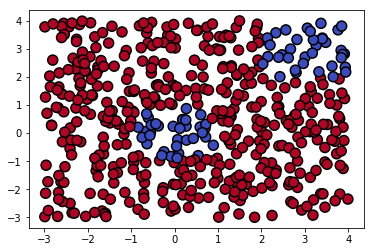

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

RANDOM_SEED = 139

def get_labels(data):
    labels = []
    for idx, item in enumerate(data):
        if item[0]**2 + item[1]**2 < 1:
            labels.append(0)
        elif item[0] > 2 and item[1] > 2:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

N = 500
train_data = 7 * np.random.random_sample((N,2)) - np.array([3,3])

train_labels = get_labels(train_data)

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

shallow_rf = RandomForestClassifier(n_estimators=5, max_depth=3, n_jobs=-1, 
                                    random_state=RANDOM_SEED)
deep_rf = RandomForestClassifier(n_estimators=5, max_depth=6, n_jobs=-1, 
                                 random_state=RANDOM_SEED)

# training the tree
shallow_rf.fit(train_data, train_labels)
deep_rf.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted_shallow = shallow_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
predicted_deep = deep_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);

Text(0.5, 1.0, 'Deep Random Forest')

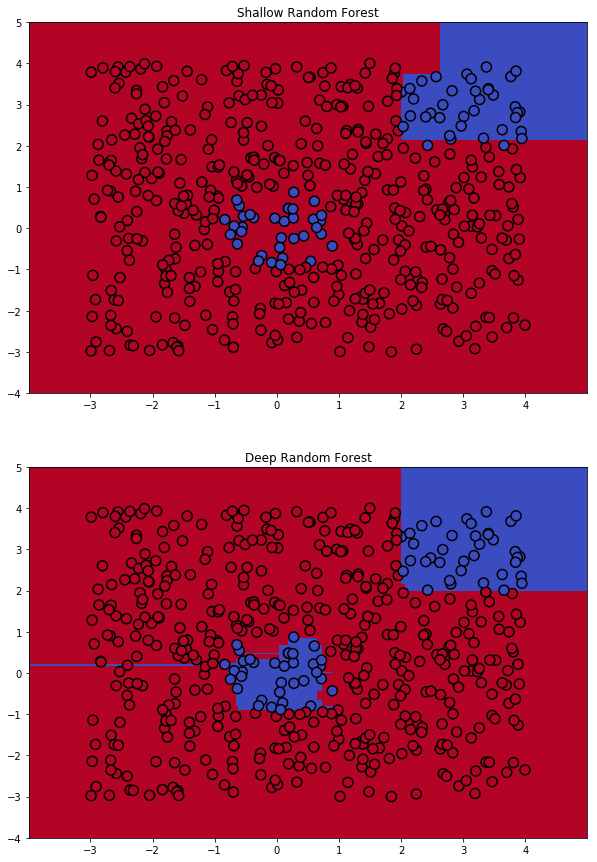

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10,15))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[1].set_title('Deep Random Forest')

## Задание 6.1.1

Как можно заметить, на первой картинке модель, сохраненная в переменную predicted_shallow, недообучается — выделяет не все синие точки на графике. После увеличения глубины в модели predicted_deep на графике практически все наблюдения отмечаются правильным классом. Как будет выглядеть график, если мы еще больше увеличим глубину (например, до 100)?

**Ответ** - График будет выглядеть похожим образом, но модель скорее всего переобучится и будет плохо работать на новых данных. Я бы оставил(-а) параметр глубины без изменений верно

**Вторая проблема** со случайным лесом состоит в том, что процесс построения деревьев является ненаправленным: каждое следующее дерево в композиции никак не зависит от предыдущих. Из-за этого для решения сложных задач необходимо огромное количество деревьев.

**Итоги урока**

В этом уроке мы вспомнили, что бэггинг и случайный лес строят композиции, независимо обучая каждый базовый алгоритм на некоторой подвыборке из обучающих данных. Однако можно предположить, что качество можно улучшить, если каждый алгоритм будет исправлять ошибки предыдущих. Эта идея реализована в **градиентном бустинге**, который мы рассмотрим в последующих занятиях.

# AdaBoost

**AdaBoost** — итеративный алгоритм построения ансамбля. На каждой новой итерации строится дерево решений, корректирующее ответы всех предыдущих. Будем пробовать на каждой итерации разделить данные деревом глубины 1 (так называемым пнём). На первых двух итерациях мы увидим следующую картинку:

<img src="../images/MLO_6_new_ada_boost_1.jpg" alt="Binary-cross-entropy" width="500" align="center">

**Размер точки** соответствует полученному ей весу за ошибочное предсказание. Мы видим, как на каждой итерации эти веса растут — пни не могут в одиночку справиться с такой задачей. Однако, когда мы произведём взвешенное голосование ранее построенных пней, мы получим искомое нами разделение:

<img src="../images/MLO_6_new_ada_boost_2.png" alt="Binary-cross-entropy" width="500" align="center">

АЛГОРИТМ
Первый ансамбль в этом разделе, который мы рассмотрим, называется AdaBoost (Adaptive Boosting). Бустинг позволяет из большого количества относительно слабых и простых моделей получить одну сильную. В нашем случае будут рассматриваться деревья решений ограниченной глубины.

## Алгоритм построение AdaBoost:

 1. Инициализируем веса объектов $w_j = \frac{1}{N}, \, j=1,2,\dots,N$
 2. Для всех $i$ от 1 до T:
    1. Строим классификатор $b_i(x)$, используя веса $w_j$.
    2. Вычисляем ошибку
    $err_i = {\sum\limits_{j=1}^{N}w_j[y_j \neq b_i(x_j)]}$
    3. Вычисляем вес нового алгоритма 
    $c_i = \frac{1}{2} \log{\frac{1-err_i}{err_i}}$, где $\frac{1}{2} = learning\_rate$
    4. Получаем новые веса объектов
    $w_j \leftarrow w_j \cdot exp\left( c_i [y_j \neq b_i(x_j)]\right), \, j = 1, \dots, N.$
    5. Нормируем веса объектов
    $w_j \leftarrow \frac{w_j}{\sum\limits_{j=1}^{N}w_j}.$
 3. Группируем полученные модели: $a_T(x) = sign\left[\sum\limits_{i=1}^{T}c_i b_i(x)\right]$

**ДОСТОИНСТВА**

 - Алгоритм прост.
 - Накладные расходы бустинга минимальны. Время построения определяется временем построения базовых моделей.
 - Показывает хорошую обобщающую способность.
 - Имеет возможность идентификации шумовых объектов.
 
**НЕДОСТАТКИ**

 - Жадное добавление алгоритмов приводит к неоптимальности композиции.
 - Склонен к переобучению при наличии шума в данных (опять же из-за экспоненциальной функции потерь).
 - Переобучается при «малом» количестве данных.

**Задание 6.2.1**

Выберите утверждения, верные для алгоритма AdaBoost:
 - выбирает подвыборки из датасета и меняет веса данных
 - строит базовые модели последовательно
 - уменьшает разброс (variance) и смещение (bias)

**Задание 6.2.2**

Какие из перечисленных ниже утверждений верны для алгоритма AdaBoost?
 - Использует мало параметров и прост в имплементации
 - Чувствителен к выбросам
 - Устойчив к переобучению (когда в данных мало шума)
 - Необходимо адаптировать для случая несбалансированных классов

# Градиентный бустинг

Теперь рассмотрим другой вид бустинга, точнее его обобщение. Со временем после создания AdaBoost исследователям удалось создать более полную модель бустинга, которая называется **Gradient Boosting**.

Принцип такой же, как в AdaBoost: каждый новый алгоритм улучшает композицию построенных ранее. Рассмотрим, как строится эта композиция.

Во-первых, определим функцию $L(y, z)$, где $y$ — истинный ответ, $z$ — прогноз алгоритма на некотором объекте. Это общий вид функции потерь, которую мы собираемся оптимизировать с помощью бустинга. Примерами возможных функций потерь являются:
 - среднеквадратичная ошибка (в задаче регрессии): $L(y,z) = (y-z)^2$
 - логистическая функция потерь (в задаче классификации): $L(y,z) = \log(1+\exp(-yz))$

Пусть к некоторому моменту обучены $T-1$ алгоритмов $b_1(x), \dots, b_{T-1}(x)$, то есть композиция имеет вид: $a_{T-1}(x) = \sum\limits_{i=1}^{T-1}b_i(x)$.

Теперь к текущей композиции добавляется ещё один алгоритм $b_T(x)$. Этот алгоритм обучается так, чтобы как можно сильнее уменьшить ошибку композиции на обучающей выборке: $\sum\limits_{j=1}^{N}L(y_j, a_{T-1}(x_j) + b(x_j)) \rightarrow \min\limits_{b}$. 

Для того чтобы найти $b$, минимизирующее функционал, задачу разбивают на две подзадачи. Сначала определим, какие значения $s_1, \dots, s_N$ должен принимать алгоритм $b_T(x_j) = s_j$, чтобы на объектах обучающей выборки ошибка была минимальной. Формально это можно представить так: $$F(s) = \sum\limits_{j=1}^{N}L(y_j, a_{T-1}(x_j) + s_j) \rightarrow \min\limits_{s}$$,
где $s=(s_1, \dots, s_N)$.

Иными словами, необходимо найти такой вектор сдвигов $s$, который будет минимизировать функцию $F(s)$.

Поскольку направление наискорейшего убывания функции задаётся направлением антиградиента, его можно принять в качестве вектора $s$: $$s = - \nabla F = \begin{bmatrix} -L_z^{'}(y_1, a_{T-1}(x_1)) \\ -L_z^{'}(y_2, a_{T-1}(x_2)) \\ \vdots \\ -L_z^{'}(y_N, a_{T-1}(x_N)) \end{bmatrix}.$$

Компоненты вектора сдвигов $s$ фактически являются теми значениями, которые на объектах обучающей выборки должен принимать новый алгоритм $b_T(x)$, чтобы минимизировать ошибку строящейся композиции.

Второй этап — построение такого алгоритма $b_T(x)$. При условии, что мы уже нашли, задача построения алгоритма $b_T$ становится классической задачей на размеченных данных, ${(x_j,s_j)}_{j=1}^{N}$ — обучающая выборка, и используется, например, квадратичная функция ошибки: $b_T(x) = arg\min_{b} \frac{1}{T} \sum\limits_{j=1}^{N}(b(x_j)-s_j)^2.$

Следует обратить особое внимание на то, что информация об исходной функции потерь $L(y, z)$, которая не обязательно является квадратичной, содержится в выражении для вектора оптимального сдвига $s$. Поэтому для большинства задач $b_T(x)$ находится, как решение задачи регрессии, используя квадратичную функцию потерь.

**АЛГОРИТМ**

Запишем последовательность шагов, которую можно запрограммировать:
1. Инициализируем композицию: $a_0(x) = b_0(x)$, т. е. добавляем первый базовый алгоритм. Например, можно использовать:
     - алгоритм $b_0(x) = 0$, который всегда возвращает ноль (в задаче регрессии);
     - более сложный $b_0(x) = \frac{1}{N}\sum\limits_{j=1}^{N}y_i$, который возвращает средний истинный ответ по всем элементам обучающей выборки (в задаче регрессии);
     - алгоритм $b_0(x) = \arg\max\limits_{y \in Y}\sum\limits_{j=1}^{N}[y_i=y]$, который всегда возвращает метку самого распространенного класса в обучающей выборке (в задаче классификации).
 
2. Итеративно повторяем следующие три шага:
    1. Вычисляем вектор сдвига 
    $s = - \nabla F = \begin{align} \begin{bmatrix} -L_z^{'}(y_1, a_{T-1}(x_1)) \\ -L_z^{'}(y_2, a_{T-1}(x_2)) \\ \vdots \\ -L_z^{'}(y_N, a_{T-1}(x_N)) \end{bmatrix} \end{align}$
    2. Строим очередной базовый алгоритм $b_T(x) = arg\min_{b} \frac{1}{T} \sum\limits_{j=1}^{N}(b(x_j)-s_j)^2.$
    3. Добавляем  в композицию $a_{T}(x) = \sum\limits_{i=1}^{T}b_i(x).$

    

3. Если выполнен критерий останова, то останавливаем итеративный процесс.   

**Борьба с переобучением**


<img src="../images/MLO_6_new_overfit_1.png" alt="Binary-cross-entropy" width="150" align="center">


<img src="../images/MLO_6_new_overfit_2.png" alt="Binary-cross-entropy" width="500" align="center">

# Бустинг. Практика

In [78]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

**Задание 6.4.1**

Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

Сделаем это следующим кодом:

In [113]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
df.head()

,Unnamed: 0,crl.tot,dollar,bang,money,n000,make,yesno
0,1,278,0.000,0.778,0.00,0.00,0.00,y
1,2,1028,0.180,0.372,0.43,0.43,0.21,y
2,3,2259,0.184,0.276,0.06,1.16,0.06,y
3,4,191,0.000,0.137,0.00,0.00,0.00,y
4,5,191,0.000,0.135,0.00,0.00,0.00,y


Из столбца *yesno* сделайте столбец *spam*, где 1 соответствует значению y (является спамом), а 0 – n (не является спамом). Удалите первый столбец (с индексом) и столбец *yesno*.

Комбинации признаков должны иметь вид **"признак1_признак2"**.

У Вас остается шесть столбцов-признаков и один столбец *spam*, который является нашей целевой переменной. Разделим их на x и у.

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?

In [114]:
# На основе признака yesno создаем целевой признак spam
df.loc[:, 'spam'] = df['yesno'].apply(lambda x: 1 if x == 'y' else 0)

# Удалите первый столбец (с индексом) и столбец yesno.
df = df.drop(columns=['yesno', 'Unnamed: 0'])

# Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга.
features = list(df.columns.drop('spam'))
pairs = list(itertools.combinations(features, 2))
for pair in pairs:
    df.loc[:, pair[0]+'_'+pair[1]] = df[pair[0]] * df[pair[1]]

# определим выборку и целевую переменную
X = df.drop(columns=['spam']).values
y = df['spam'].values    
    
df.head()

,crl.tot,dollar,bang,money,n000,make,spam,crl.tot_dollar,crl.tot_bang,crl.tot_money,...,dollar_bang,dollar_money,dollar_n000,dollar_make,bang_money,bang_n000,bang_make,money_n000,money_make,n000_make
0,278,0.000,0.778,0.00,0.00,0.00,1,0.000,216.284,0.00,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.0000
1,1028,0.180,0.372,0.43,0.43,0.21,1,185.040,382.416,442.04,...,0.066960,0.07740,0.07740,0.03780,0.15996,0.15996,0.07812,0.1849,0.0903,0.0903
2,2259,0.184,0.276,0.06,1.16,0.06,1,415.656,623.484,135.54,...,0.050784,0.01104,0.21344,0.01104,0.01656,0.32016,0.01656,0.0696,0.0036,0.0696
3,191,0.000,0.137,0.00,0.00,0.00,1,0.000,26.167,0.00,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.0000
4,191,0.000,0.135,0.00,0.00,0.00,1,0.000,25.785,0.00,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.0000


**Задание 6.4.2**

Разделим получившися данные на обучающую и тестовую выборки в соотношение 80:20. Обучите модель GradientBoostingClassifier (из библиотеки sklearn) с параметрами по умолчанию (на момент создания урока это learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None).

Во всех методах, где присутствует случайность, укажите random_state=42.

Это будет наш baseline. Укажите точность  на тестовой выборке (параметр score), округлив до третьего знака после точки-разделителя.

In [53]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

model = GradientBoostingClassifier(learning_rate=0.1, 
                                   n_estimators=100,
                                   max_depth=3, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   subsample=1,
                                   max_features=None,
                                  random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(round(accuracy_score(y_test, y_pred), 3))

0.865


**Задание 6.4.3**

Воспользуйтесь методом feature_importances_. С его помощью вы можете оценить вклад каждого признака в обучение модели. Постройте столбчатую диаграмму, где по горизонтали указаны названия признаков, а по вертикали их важность. В ответе укажите третий по важности признак (без кавычек и пробелов).

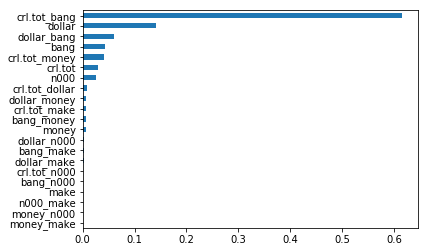

In [77]:
imp = model.feature_importances_
feat = df.columns.drop('spam')

ds = pd.Series(imp, index=feat, name='feature_importances').sort_values()
ds.plot(kind='barh')

**Задание 6.4.4**

Теперь перейдем к подбору параметров в модели. Для этого в библиотеке scikit-learn есть метод GridSearchCV. Ему на вход подается модель, список параметров и способ оценивания. При запуске метода fit модель обучается со всеми возможными комбинациями параметров, лучшей комбинацией параметров становятся та, при которой значение метрики максимально.

Укажите в качестве estimator градиетный бустинг с параметрами по дефолту и random_state=42. В параметре scoring укажите 'accuracy', n_jobs=-1, cv=5.

Сетку параметров задайте такой:
    
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

In [88]:
# Создаем сетку поиска 
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

# в качестве estimator - градиетный бустинг с параметрами по дефолту и random_state=42
model = GradientBoostingClassifier(max_depth=3, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   subsample=1,
                                   max_features=None,
                                   random_state=RANDOM_STATE)

#
clf = GridSearchCV(estimator=model, 
                   param_grid=param_grid, 
                   scoring='accuracy', 
                   n_jobs=-1, 
                   cv=5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(random_state=42, subsample=1),
             n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500,
                                          1750]},
             scoring='accuracy')

In [91]:
# View best hyperparameters
best_params = clf.best_estimator_.get_params()

print('Лучшее learning_rate:', best_params['learning_rate'])
print('Лучшее n_estimators:', best_params['n_estimators'])
print('Accuracy для лучшей модели', round(clf.best_score_, 3))

Лучшее learning_rate: 0.01
Лучшее n_estimators: 1250
Accuracy для лучшей модели 0.884


**Задание 6.4.6**

Теперь воспользуемся GridSearchCV для подбора максимальной глубины (max_depth). В качестве estimator используйте градиентный бустинг с раннеее подобранными параметрами и random_state=42. Переберите все значения max_depth от 5 до 15 включительно. В ответ запишите значение параметра, при котором точность максимальна.

In [93]:
# Создаем сетку поиска 
param_grid = {'max_depth': list(range(5, 16, 1))}

# в качестве estimator - градиетный бустинг с раннеее подобранными параметрами и random_state=42
model = GradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                   learning_rate=best_params['learning_rate'],
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   subsample=1,
                                   max_features=None,
                                   random_state=RANDOM_STATE)

#
clf = GridSearchCV(estimator=model, 
                   param_grid=param_grid, 
                   scoring='accuracy', 
                   n_jobs=-1, 
                   cv=5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  n_estimators=1250,
                                                  random_state=42,
                                                  subsample=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
             scoring='accuracy')

In [94]:
# View best hyperparameters
best_params = clf.best_estimator_.get_params()

print('Лучшее max_depth:', best_params['max_depth'])
print('Accuracy для лучшей модели', round(clf.best_score_, 3))

Лучшее max_depth: 5
Accuracy для лучшей модели 0.885


**Задание 6.4.7**


Может показаться, что, научившись запускать готовые фукнции из библиотек и настраивать параметры, мы абсолютно готовы к работе. Однако на поле боя нас могут подстерегать еще опасности — *legacy code*, то есть код, написанный кем-то до вас. Может быть, его можно было бы и улучшить, но на нём уже столько всего надстроено, что переписывать всё практически невозможно.

А ещё часто будет возникать необходимость просто понять код коллеги или сделать code review (грубо говоря, это анализ кода на предмет ошибок и расхождения в стиле). Во всех этих ситуациях необходим навык быcтрого чтения кода.

Поэтому в качестве примера в этом задании мы предлагаем изучить код для реализации **AdaBoost** с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками (вычисление ошибки и веса алгоритма) на всех признаках, получившихся после всех преобразований в предыдущем датасете (до разделения выборки на обучающую и тестовую). Параметр learning_rate возьмите равным 0.001, М = 10. В ответ запишите точность, округленную до трёх знаков после точки-разделителя.

За основу нужно взять следующий код:

**Алгоритм построение AdaBoost**:

 1. Инициализируем веса объектов $w_j = \frac{1}{N}, \, j=1,2,\dots,N$
 2. Для всех $i$ от 1 до T:
    1. Строим классификатор $b_i(x)$, используя веса $w_j$.
    2. Вычисляем ошибку
    $err_i = {\sum\limits_{j=1}^{N}w_j[y_j \neq b_i(x_j)]}$
    3. Вычисляем вес нового алгоритма 
    $c_i = \frac{1}{2} \log{\frac{1-err_i}{err_i}}$, где $\frac{1}{2} = learning\_rate$
    4. Получаем новые веса объектов
    $w_j \leftarrow w_j \cdot exp\left( c_i [y_j \neq b_i(x_j)]\right), \, j = 1, \dots, N.$
    5. Нормируем веса объектов
    $w_j \leftarrow \frac{w_j}{\sum\limits_{j=1}^{N}w_j}.$
 3. Группируем полученные модели: $a_T(x) = sign\left[\sum\limits_{i=1}^{T}c_i b_i(x)\right]$

In [119]:
from math import log

def AdaBoost_scratch(X, y, M=10, learning_rate=1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        estimator_error = (sample_weight * incorrect).sum()
        
        # Вычисляем вес нового алгоритма
        estimator_weight =  learning_rate * log((1 - estimator_error) / estimator_error)

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error)
        estimator_weight_list.append(estimator_weight)
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [120]:
estimator_list, estimator_weight_list, sample_weight_list = AdaBoost_scratch(X, y, M=10, learning_rate=0.001)

Accuracy =  0.8228645946533363


# Стекинг

**Стекинг (stacking)** — агрегация ответов моделей машинного обучения при помощи ещё одной модели машинного обучения. Подход использует понятие **базовых моделей**, каждая из которых обучается независимо от остальных, и **мета-модели**, которая использует предсказания базовых моделей как признаки.

Правила стекинга:
 - Обучать мета-модели нужно на новых для базовых моделей данных. Так избегается **data leak**, появляющийся при оценке алгоритмов на обучающей выборке.
 - Можно использовать подходы из **кросс-валидации** (разбиение по фолдам, бутстрап) для получения различных моделей.
 - Лучше применять **регрессоры** для мета-моделей.
 - Для старта лучше взять простую мета-модель, например, линейную регрессию. В случае классификации — для агрегации вероятности классов. Этот частный случай называют **блендингом (blending)**.
 - Брать в качестве базовых моделей модели различной природы.
 - Обучать модель не только на истинный таргет, но и на **прокси таргет**, например, на важный признак, который выявили во время исследования данных.
 - Делать стекинг с большим количеством **уровней** при наличии достаточного количества данных, времени и усилий, что на практике редко.

# Задания по Стекингу

Все задания выполняются на основе датасета:

In [138]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

In [122]:
dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

**Задание 6.6.1**

В скринкасте мы разобрали схему генерации признаков в стекинге, когда для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке. Реализуйте схему, когда вместо этого производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения.

***Логика решения***:
 1. Создадим X_meta_test, заполним его нулями (по аналогии с X_meta_train);
 2. Далее на каждом шаге, где мы обучаем folded_clf.fit (X_fold_train, y_fold_train) и его предсказания на X_fold_predict запихиваем в X_meta_train[predict_fold_index] добавим еще одну строку, где в X_meta_test будем добавлять предсказания вероятностей folded_clf на X_test. Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить, а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);
 3. После цикла останется только усреднить все эти массивы, это и будет наш X_meta_test.

In [ ]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.     
    Они являются вероятностями классов при решении задачи многоклассовой классификации.  
    
    :arg clf: классификатор    
    :args X_train, y_train: обучающая выборка    
    :arg X_test: признаки тестовой выборки    
    :arg cv: класс, генерирующий фолды (KFold)    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    """
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    # Создадим X_meta_test, заполним его нулями (по аналогии с X_meta_train)
    X_meta_test = np.zeros((len(X_test), n_classes), dtype=np.float32)
    
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
        
        #в X_meta_test будем добавлять предсказания на обученной folded_clf на X_test. 
        # Значения будем сразу суммировать.
        X_meta_test += folded_clf.predict_proba(X_test)

    # в конце их нужно будет разделить на количество сплитов 
    # (количество массивов равно количеству сплитов в кросс - валидации)
    X_meta_test = X_meta_test / cv.n_splits

    return X_meta_train, X_meta_test

**Подсказка**
 - Во всех случаях, когда модель принимает random_state — обязательно указывайте его равным 42
 - На разных версиях sklearn ответы могут отличаться
 - В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания.
 
 
**Для следующих заданий используйте этот код:**

In [126]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [127]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [128]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

**Задание 6.6.2**

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
 - логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000
 - логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000
 - случайный лес из 300 деревьев
 - градиентный бустинг из 200 деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. 
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [134]:
RANDOM_STATE = 42

classifiers = [
    LogisticRegression(C=0.001, penalty='l1', solver='saga', multi_class='ovr', max_iter=2000, random_state=RANDOM_STATE),
    LogisticRegression(C=0.001, penalty='l2', solver='saga', multi_class='multinomial', max_iter=2000, random_state=RANDOM_STATE),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
]

meta_classifier = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs')


In [135]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|██████████| 4/4 [02:11<00:00, 32.95s/it]


In [140]:
compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.978082

**Задание 6.6.3**

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
 - случайный лес из 300 деревьев
 - случайный лес из 200 экстремальных деревьев
 
Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. 
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [141]:
RANDOM_STATE = 42

classifiers = [ 
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs')

In [142]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|██████████| 2/2 [00:13<00:00,  6.63s/it]


In [143]:
compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.982421

**Задание 6.6.4**

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
 - метод ближайшего соседа (k-NN) со стандартными параметрами
 - случайный лес из 300 экстремальных деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. 
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [146]:
RANDOM_STATE = 42

classifiers = [ 
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs')

In [147]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


In [148]:
compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

/notebooks/home/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.989904

**Задание 6.6.5**

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
 - логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимоей количество итераций — 2000
 - метод ближайшего соседа со стандартными параметрами
 - случайный лес из 300 экстремальных деревьев
 - AdaBoost со стандартными параметрами

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'. 
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [152]:
RANDOM_STATE = 42

classifiers = [ 
    LogisticRegression(C=0.001, penalty='l1', solver='saga', multi_class='ovr', max_iter=2000, random_state=RANDOM_STATE),
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    AdaBoostClassifier(random_state=RANDOM_STATE)
]

meta_classifier = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs')

In [153]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|██████████| 4/4 [00:40<00:00, 10.14s/it]


In [154]:
compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.987404

**Задание 6.6.6**

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
 - случайный лес из 300 деревьев
 - случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс StratifiedKFold, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов). Для корректной работы необходимо подправить код в функции compute_meta_feature. 

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric. Количество фолдов = 10

In [157]:
RANDOM_STATE = 42

classifiers = [ 
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [158]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train, y_train) # Для корректной работы необходимо подправить код в функции compute_meta_feature.
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [159]:
stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|██████████| 2/2 [00:15<00:00,  7.90s/it]


In [160]:
compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

0.983918

**Задание 6.6.7**

В предыдущей задаче измените 10 фолдов на 20. Укажите полученное качество.

In [161]:
classifiers = [ 
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = LogisticRegression(penalty='none', multi_class='auto', solver='lbfgs')

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=RANDOM_STATE)

stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

100%|██████████| 2/2 [00:29<00:00, 14.60s/it]


0.984228

**Задание 6.6.8**

В предыдущей задаче укажите количество фолдов равным 5 и поменяйте мета-алгоритм на случайный лес со стандартными параметрами. Укажите полученное качество.

In [163]:
classifiers = [ 
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = RandomForestClassifier(random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


0.981661

**Задание 6.6.9**

В предыдущей задаче поменяйте мета-алгоритм на метод ближайших соседей (k-NN) со стандартными параметрами. Укажите полученное качество.

In [164]:
classifiers = [ 
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = KNeighborsClassifier(n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


0.98417

**Задание 6.6.10**

В предыдущей задаче поменяйте мета-алгоритм на градиентный бустинг со стандартными параметрами. Укажите полученное качество.

In [166]:
classifiers = [ 
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = GradientBoostingClassifier(random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


0.984925

**Задание 6.6.11**

Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
 - случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
 - случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс StratifiedKFold, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов). 
Для генерации фолдов используйте класс StratifiedKFold и поправленный Вами ранее код в функции compute_meta_feature. 
Выполните разбиение на 3 фолда. 

Как мета-алгортм используйте случайный лес из 100 экстремальных деревьев. Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [168]:
classifiers = [ 
    RandomForestClassifier(n_estimators=300, criterion="gini", max_depth=24, n_jobs=-1, random_state=RANDOM_STATE),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE)
]

meta_classifier = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

stacked_features_train, stacked_features_test = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf=meta_classifier, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test)

100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


0.986498

**Задание 6.6.12**

Обучите на тренировочной выборке следующие алгоритмы:
 - случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
 - случайный лес из 300 экстремальных деревьев
 - логистическую регрессию со стандартными параметрами

Усредните их ответы на тестовой выборке методом сложения предсказаний и затем взятия функции **argmax: answer = (prediction1 + prediction2 + prediction3).argmax(axis = 1)**.

Посчитайте качество, аналогично функции **compute_metric (F1-score с макро-усреднением, округленный до 6 знака)**.

***(Решение эксперта)***
Здравствуйте! 

нам нужно усреднить ответы алгоритмов. Усреднением здесь мы добиваемся большей точности предсказаний.
Однако усреднять здесь (в случае задачи классификации) нужно не метки классов, возвращаемые методом predict() (что некорректно: допустим, три наши алгоритма дали такие предсказания меток классов: 1, 1 и 7 - усреднение меток здесь даёт ответ 3, что противоречит здравому смыслу).

"Усреднять" нужно "сырые" ответы - вероятности принадлежности классов, возвращаемые методом predict_proba()  : вернёт таблицу с числом столбцов равным числу классов - в нашем случае 10. По столбцам будут расположены вероятности принадлежности объекта к классам.

Это делается следующим образом: для каждого объекта мы складываем вероятности, выданные алгоритмами и делим их на количество (усредняем). В качестве предсказания мы берём класс, для которого получившаяся вероятность максимальна.
В коде это может выглядеть так:

In [169]:
def compute_predicts(classifiers, X_train, y_train, X_test):
    predicts = []
    for clf in classifiers:
        clf.fit(X_train, y_train)
        predicts.append(clf.predict_proba(X_test))
    return predicts

predicts = compute_predicts([ 
    RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=24, n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42), 
    LogisticRegression()
], X_train, y_train, X_test)

y_test_pred = np.sum(predicts, axis=0).argmax(axis=1)
print(np.round(f1_score(y_test, y_test_pred, average='macro'), 6))

0.976259


/notebooks/home/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


argmax() как раз и используется, чтобы получить индекс столбца, для которого вероятность максимальна.
P.S. я использую np.sum()  вместо np.mean() , но тут разницы нет, поскольку мне нужен лишь индекс максимального элемента в строке, а он не измениться, если весь массив умножить/разделить на какое-то (положительное) число